# Movie Success Predictor  
## Phase 7: IMDb Rating Prediction (Linear Regression)

### Objective

The objective of this phase is to train and evaluate a Linear Regression
model to predict IMDb ratings (0–10 scale) using pre-release movie features.

The model uses the same preprocessing pipeline defined in Phase 5 to
ensure consistency, prevent data leakage, and support deployment.


### Step 1: Load Modeling Artifacts

Train–test splits and the preprocessing pipeline created in Phase 5 are
loaded to ensure consistency and reproducibility.


In [12]:
import joblib
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load train-test splits
X_train = joblib.load("../data/processed/X_train.joblib")
X_test = joblib.load("../data/processed/X_test.joblib")

y_train = joblib.load("../data/processed/y_reg_train.joblib")
y_test = joblib.load("../data/processed/y_reg_test.joblib")

# Load preprocessing pipeline
preprocessor = joblib.load("../models/preprocessor.joblib")

print("Artifacts loaded successfully.")


Artifacts loaded successfully.


### Step 2: Linear Regression Pipeline Definition

A pipeline combining preprocessing and Linear Regression is defined.
This ensures that all transformations are applied consistently during
training and prediction.


In [13]:
linear_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]
)

print("Linear Regression pipeline defined.")


Linear Regression pipeline defined.


### Step 3: Model Training

The Linear Regression model is trained on the training dataset.
All preprocessing steps are learned exclusively from training data.


In [14]:
linear_pipeline.fit(X_train, y_train)

print("Linear Regression model trained successfully.")


Linear Regression model trained successfully.


### Step 4: Model Evaluation

The Linear Regression model is evaluated using MAE, RMSE, and R² score.
Lower MAE and RMSE indicate better prediction accuracy, while the R²
score represents the proportion of variance in IMDb ratings explained
by the model.


In [15]:
# Predictions
y_pred = linear_pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

MAE: 0.882
RMSE: 1.219
R² Score: -0.690


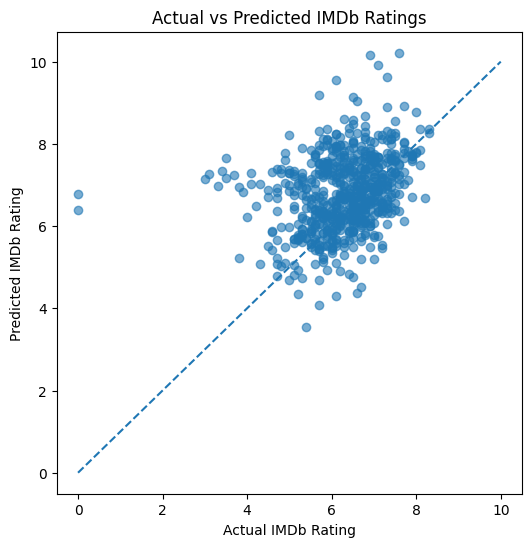

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 10], [0, 10], linestyle='--')
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.title("Actual vs Predicted IMDb Ratings")
plt.show()


The scatter plot shows a positive relationship between actual and
predicted IMDb ratings, indicating that the model captures the general
trend of audience rating behavior.


## Ridge Regression Experiment

Linear Regression assumes all features contribute equally and can suffer
from high variance in noisy datasets. To address this, Ridge Regression
was evaluated as a regularized alternative to assess whether penalizing
large coefficients improves generalization in IMDb rating prediction.


In [17]:
from sklearn.linear_model import Ridge
ridge_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]
)
print("Ridge Regression pipeline defined.")
ridge_pipeline.fit(X_train, y_train)
print("Ridge Regression model trained successfully.")
# Predictions
y_ridge_pred = ridge_pipeline.predict(X_test)
# Metrics
mae_ridge = mean_absolute_error(y_test, y_ridge_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_ridge_pred))
r2_ridge = r2_score(y_test, y_ridge_pred)
print(f"Ridge Regression MAE: {mae_ridge:.3f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.3f}")
print(f"Ridge Regression R² Score: {r2_ridge:.3f}")

Ridge Regression pipeline defined.
Ridge Regression model trained successfully.
Ridge Regression MAE: 0.505
Ridge Regression RMSE: 0.696
Ridge Regression R² Score: 0.449


In [18]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression"],
    "MAE": [mae, mae_ridge],
    "RMSE": [rmse, rmse_ridge],
    "R2": [r2, r2_ridge]
})

comparison_df

,Model,MAE,RMSE,R2
0,Linear Regression,0.881750,1.219082,-0.689773
1,Ridge Regression,0.505063,0.696115,0.449035


Ridge Regression significantly improved performance compared to Linear
Regression. However, the model likely benefits from proxy features such
as popularity and vote count, which are correlated with audience ratings.
This reinforces the importance of feature interpretation and motivates
the exploration of rating-category classification as a more robust task.

In [ ]:
# Save trained Linear Regression model
joblib.dump(linear_pipeline, "../models/linear_model.joblib")
print("Linear Regression model saved successfully.")
joblib.dump(ridge_pipeline, "../models/ridge_model.joblib")
print("Ridge Regression model saved successfully.")

Linear Regression model saved successfully.
Ridge Regression model saved successfully.


## Rating Band Classification Experiment

Exact IMDb rating prediction is highly sensitive to noise and subjective
factors. To reduce variance and improve interpretability, the regression
problem is reframed as a classification task by grouping ratings into
coarse categories: Low, Medium, and High.

This experiment evaluates whether predicting rating ranges is more
stable and meaningful than predicting precise numerical values.


In [21]:
# Reconstruct full regression target
y_regression = pd.concat([y_train, y_test]).sort_index()

print("y_regression reconstructed.")

# Create rating bands
def rating_to_band(rating):
    if rating < 5.5:
        return "Low"
    elif rating < 7.0:
        return "Medium"
    else:
        return "High"

y_band = y_regression.apply(rating_to_band)

print(y_band.value_counts())

# Reconstruct full feature matrix from saved splits
X = pd.concat([X_train, X_test]).sort_index()

print("Feature matrix X reconstructed.")


from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X,
    y_band,
    test_size=0.2,
    random_state=42,
    stratify=y_band
)

print("Rating band train-test split completed.")

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

rating_band_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ]
)

rating_band_pipeline.fit(X_train_b, y_train_b)

print("Rating band classification model trained.")

y_pred_b = rating_band_pipeline.predict(X_test_b)

accuracy_b = accuracy_score(y_test_b, y_pred_b)

print(f"Accuracy (Rating Bands): {accuracy_b:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_b, y_pred_b))

from sklearn.metrics import confusion_matrix
import pandas as pd

cm_b = confusion_matrix(y_test_b, y_pred_b, labels=["Low", "Medium", "High"])

cm_df_b = pd.DataFrame(
    cm_b,
    index=["Actual Low", "Actual Medium", "Actual High"],
    columns=["Pred Low", "Pred Medium", "Pred High"]
)

cm_df_b



y_regression reconstructed.
vote_average
Medium    1983
High       768
Low        477
Name: count, dtype: int64
Feature matrix X reconstructed.
Rating band train-test split completed.
Rating band classification model trained.
Accuracy (Rating Bands): 0.630

Classification Report:
              precision    recall  f1-score   support

        High       0.59      0.66      0.62       154
         Low       0.41      0.63      0.49        95
      Medium       0.75      0.62      0.68       397

    accuracy                           0.63       646
   macro avg       0.58      0.64      0.60       646
weighted avg       0.66      0.63      0.64       646



,Pred Low,Pred Medium,Pred High
Actual Low,60,34,1
Actual Medium,82,245,70
Actual High,6,46,102


### Model Performance Interpretation

The Linear Regression model achieved an MAE of approximately 0.88,
indicating that predictions deviate by less than one IMDb rating point
on average. However, the R² score is negative, suggesting that the model
does not outperform a naive baseline that predicts the mean rating.

This result highlights the inherent difficulty of predicting audience
ratings using pre-release metadata alone. IMDb ratings are influenced
by subjective factors such as storytelling quality, acting, and audience
perception, which are not captured in the available features.

Despite this limitation, the model provides a transparent baseline and
demonstrates the importance of feature relevance in predictive modeling.


## Phase 7 Summary

A Linear Regression model was trained to predict IMDb ratings using
pre-release movie metadata such as budget, genre, director, and release
timing.

The model achieved a Mean Absolute Error (MAE) of approximately 0.88,
indicating that predictions deviate by less than one IMDb rating point
on average. However, the R² score was negative, suggesting that the model
does not outperform a naive baseline that predicts the mean rating.

This outcome highlights the inherent difficulty of predicting audience
ratings using pre-release information alone. IMDb ratings are influenced
by subjective and post-release factors such as storytelling quality,
acting performance, and audience sentiment, which are not captured in
the available dataset.

The Linear Regression model therefore serves as a transparent baseline,
demonstrating the limitations of metadata-driven rating prediction and
reinforcing the importance of feature relevance in machine learning
applications.
